In [1]:
from demo_track import Predictor
import torch
from torch2trt import TRTModule
import numpy as np
import torchvision
import cv2
# import sys
import os
# sys.path.append('/home/leejaehyeok/trackingProject/ocsort/OC_SORT/')

/home/leejaehyeok/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trt_file = '/home/leejaehyeok/trackingProject/ocsort/OC_SORT/YOLOX_outputs/yolox_dancetrack_test/model_trt.pth'
org_file = '/home/leejaehyeok/trackingProject/ocsort/OC_SORT/pretrained/ocsort_dance_model.pth.tar'
img_file = '/home/leejaehyeok/trackingProject/ocsort/OC_SORT/samplepeople.jpg'

In [3]:
def preproc(img, input_size, mean, std, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3)) * 114.0
    else:
        padded_img = np.ones(input_size) * 114.0
    #img = np.array(image)
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.float32)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img[:, :, ::-1]
    padded_img /= 255.0
    
    if mean is not None:
        padded_img -= mean
    if std is not None:
        padded_img /= std
        
    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r

In [4]:

            
# x = torch.ones((1, 3, 800, 1440), device="cuda")
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(trt_file))


[07/19/2022-23:09:43] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.


<All keys matched successfully>

In [5]:
x = cv2.imread(img_file)
x1 = x
x = np.array(x)
print(x.shape)
x, _ = preproc(x, (800, 1440), (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
x = torch.from_numpy(x).unsqueeze(0).float().to('cuda:0')

print(x.shape)

(521, 464, 3)
torch.Size([1, 3, 800, 1440])


In [6]:
with torch.no_grad():
    outputs = model_trt(x)

[07/19/2022-23:09:48] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. Please use enqueueV2() instead.
[07/19/2022-23:09:48] [TRT] [W] Also, the batchSize argument passed into this function has no effect on changing the input shapes. Please use setBindingDimensions() function to change input shapes instead.


In [7]:
def decode_outputs(outputs, dtype):
    grids = []
    strides = []
    hw = [[100,180],[50,90],[25,45]]
    cls_strides = [8, 16, 32]
    for (hsize, wsize), stride in zip(hw, cls_strides):
        yv, xv = torch.meshgrid([torch.arange(hsize), torch.arange(wsize)])
        a = torch.stack((xv,yv))
        print(a.shape)
        grid = torch.stack((xv, yv), 2).view(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        strides.append(torch.full((*shape, 1), stride))
    print(dtype)
    grids = torch.cat(grids, dim=1).type(dtype)
    strides = torch.cat(strides, dim=1).type(dtype)

    outputs[..., :2] = (outputs[..., :2] + grids) * strides
    outputs[..., 2:4] = torch.exp(outputs[..., 2:4]) * strides
    return outputs

In [8]:
outputs = decode_outputs(outputs, dtype=outputs.type())

torch.Size([2, 100, 180])
torch.Size([2, 50, 90])
torch.Size([2, 25, 45])
torch.cuda.FloatTensor


/home/leejaehyeok/.conda/envs/ocsort/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(
            image_pred[:, 5 : 5 + num_classes], 1, keepdim=True
        )

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # _, conf_mask = torch.topk((image_pred[:, 4] * class_conf.squeeze()), 1000)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue
        # import pdb; pdb.set_trace()
        if detections.shape[1] == 1:
            detections = detections.squeeze(0)
        try:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre
            )
        except:
            #print("pdb should be uploaded")
            import pdb; pdb.set_trace()
        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output

In [10]:
outputss = postprocess(outputs, 1, 0.1, 0.7)
print(outputss[0].shape)
print(outputss[0])

torch.Size([8, 7])
tensor([[192.0702,  31.2105, 328.1173, 393.1645,   0.9985,   0.9805,   0.0000],
        [ 26.8002,  26.0286, 146.0435, 388.6902,   0.9966,   0.9814,   0.0000],
        [ 16.3157, 409.7150, 127.1375, 798.0350,   0.9990,   0.9790,   0.0000],
        [196.9685, 414.3482, 330.9065, 795.9019,   0.9980,   0.9795,   0.0000],
        [391.8076,  14.7951, 505.0361, 394.8612,   0.9990,   0.9785,   0.0000],
        [386.4258, 419.2980, 487.8242, 795.6707,   0.9995,   0.9766,   0.0000],
        [577.7744,  21.5551, 681.8818, 388.4917,   0.9985,   0.9766,   0.0000],
        [554.2709, 404.1043, 687.1666, 800.0832,   0.9990,   0.9707,   0.0000]],
       device='cuda:0')


In [12]:
from trackers.ocsort_tracker.ocsort import OCSort
tracker = OCSort(det_thresh=0.6, iou_threshold=0.3, use_byte=False)
online_targets = tracker.update(outputs[0], [521, 464], (800, 1440))

In [13]:
print(online_targets)

[[361.13537592 262.59521416 448.02239996 520.98065253  72.        ]
 [127.86682086 269.82388135 215.60650678 518.31073169  71.        ]
 [127.67675028 269.88314796 215.58795156 517.88513207  70.        ]
 [127.90154342 269.68142866 215.47001572 518.16827227  69.        ]
 [361.104248   263.17294248 447.48367314 521.05419985  68.        ]
 [360.96893238 263.17294045 447.51721264 521.05420188  67.        ]
 [361.15210011 263.08136086 447.70037792 520.96258446  66.        ]
 [251.66154502 272.96609531 317.63272072 518.07879605  65.        ]
 [251.59877053 273.18994234 317.63442955 518.30267241  64.        ]
 [251.33541891 273.2561038  317.69427469 518.36883517  63.        ]
 [128.14157025 270.09682952 215.45385822 518.09881868  62.        ]
 [128.10400439 270.12735072 215.50160169 518.12933262  61.        ]
 [128.27575737 269.84423929 215.5028376  518.33105368  60.        ]
 [ 10.73242302 266.51147144  82.90511589 519.40484936  59.        ]
 [ 10.81046959 266.60306056  82.84233574 519.496

In [14]:
def get_color(idx):
    idx = idx * 3
    color = ((37 * idx) % 255, (17 * idx) % 255, (29 * idx) % 255)

    return color

def plot_tracking(image, tlwhs, obj_ids, scores=None, frame_id=0, fps=0., ids2=None):
    # 이미 preproc에서 하므로 필요 없음
    #im = np.ascontiguousarray(np.copy(image))
    im = image
    im_h, im_w = im.shape[:2]

    top_view = np.zeros([im_w, im_w, 3], dtype=np.uint8) + 255

    #text_scale = max(1, image.shape[1] / 1600.)
    #text_thickness = 2
    #line_thickness = max(1, int(image.shape[1] / 500.))
    text_scale = 2
    text_thickness = 2
    line_thickness = 3

    radius = max(5, int(im_w/140.))
    cv2.putText(im, 'frame: %d fps: %.2f num: %d' % (frame_id, fps, len(tlwhs)),
                (0, int(15 * text_scale)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=2)

    for i, tlwh in enumerate(tlwhs):
        x1, y1, w, h = tlwh
        intbox = tuple(map(int, (x1, y1, x1 + w, y1 + h)))
        
        # median filter
        """
        distance = []
        kernel = 5
        for dx in range(-kernel, kernel+1):
            for dy in range(-kernel, kernel+1):
                x = cx + dx
                y = cy + dy
                if (x <0) or (y<0):
                    continue
                depth_value = depthimg[x,y]

                distance.append(depth_value)
        distance.sort()
        depth = distance[len(distance)//2]
        """
        
        obj_id = int(obj_ids[i])
        id_text = '{}'.format(int(obj_id))
        if ids2 is not None:
            id_text = id_text + ', {}'.format(int(ids2[i]))
        color = get_color(abs(obj_id))
        cv2.rectangle(im, intbox[0:2], intbox[2:4], color=color, thickness=line_thickness)
        cv2.putText(im, id_text, (intbox[0], intbox[1]), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                    thickness=text_thickness)
    return im

In [19]:
online_tlwhs = []
online_ids = []
results = []
frame_id = 0
for t in online_targets:
    tlwh = [t[0], t[1], t[2] - t[0], t[3] - t[1]]
    tid = t[4]
    vertical = tlwh[2] / tlwh[3] > 1.6 # threshold for filtering out boxes of which aspect ratio are above the given value
    if tlwh[2] * tlwh[3] > 10 and not vertical: # 10: filter out tiny boxes
        online_tlwhs.append(tlwh)
        online_ids.append(tid)
        results.append(
            f"{frame_id},{tid},{tlwh[0]:.2f},{tlwh[1]:.2f},{tlwh[2]:.2f},{tlwh[3]:.2f},1.0,-1,-1,-1\n"
        )
print(len(results))
online_im = plot_tracking(
    x1, online_tlwhs, online_ids, frame_id=frame_id + 1, fps=0
)

72


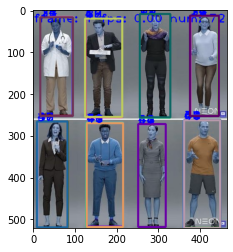

In [21]:
from matplotlib import pyplot as plt

plt.imshow(online_im)